In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [4]:
df.dtypes

id                         int64
surgery                   object
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube          object
nasogastric_reflux        object
nasogastric_reflux_ph    float64
rectal_exam_feces         object
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
abdomo_protein           float64
surgical_lesion           object
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                   object
outcome                   object
dtype: object

In [5]:
df.isna().sum().sum()

765

In [6]:
df.select_dtypes(include = 'object').isna().sum().sum()

765

In [7]:
def plot_boxplots(df):
    features = df.select_dtypes(exclude = 'object').columns
    num_features = len(features)
    fig, axes = plt.subplots(nrows=num_features//2, ncols=2, figsize=(15, 15))
    for i, feature in enumerate(features):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
       
        sns.boxplot(x=df[feature], ax=ax)
        ax.set_title(f'Boxplot of {feature}', fontsize=14)
    
    plt.tight_layout()
    
    plt.show()

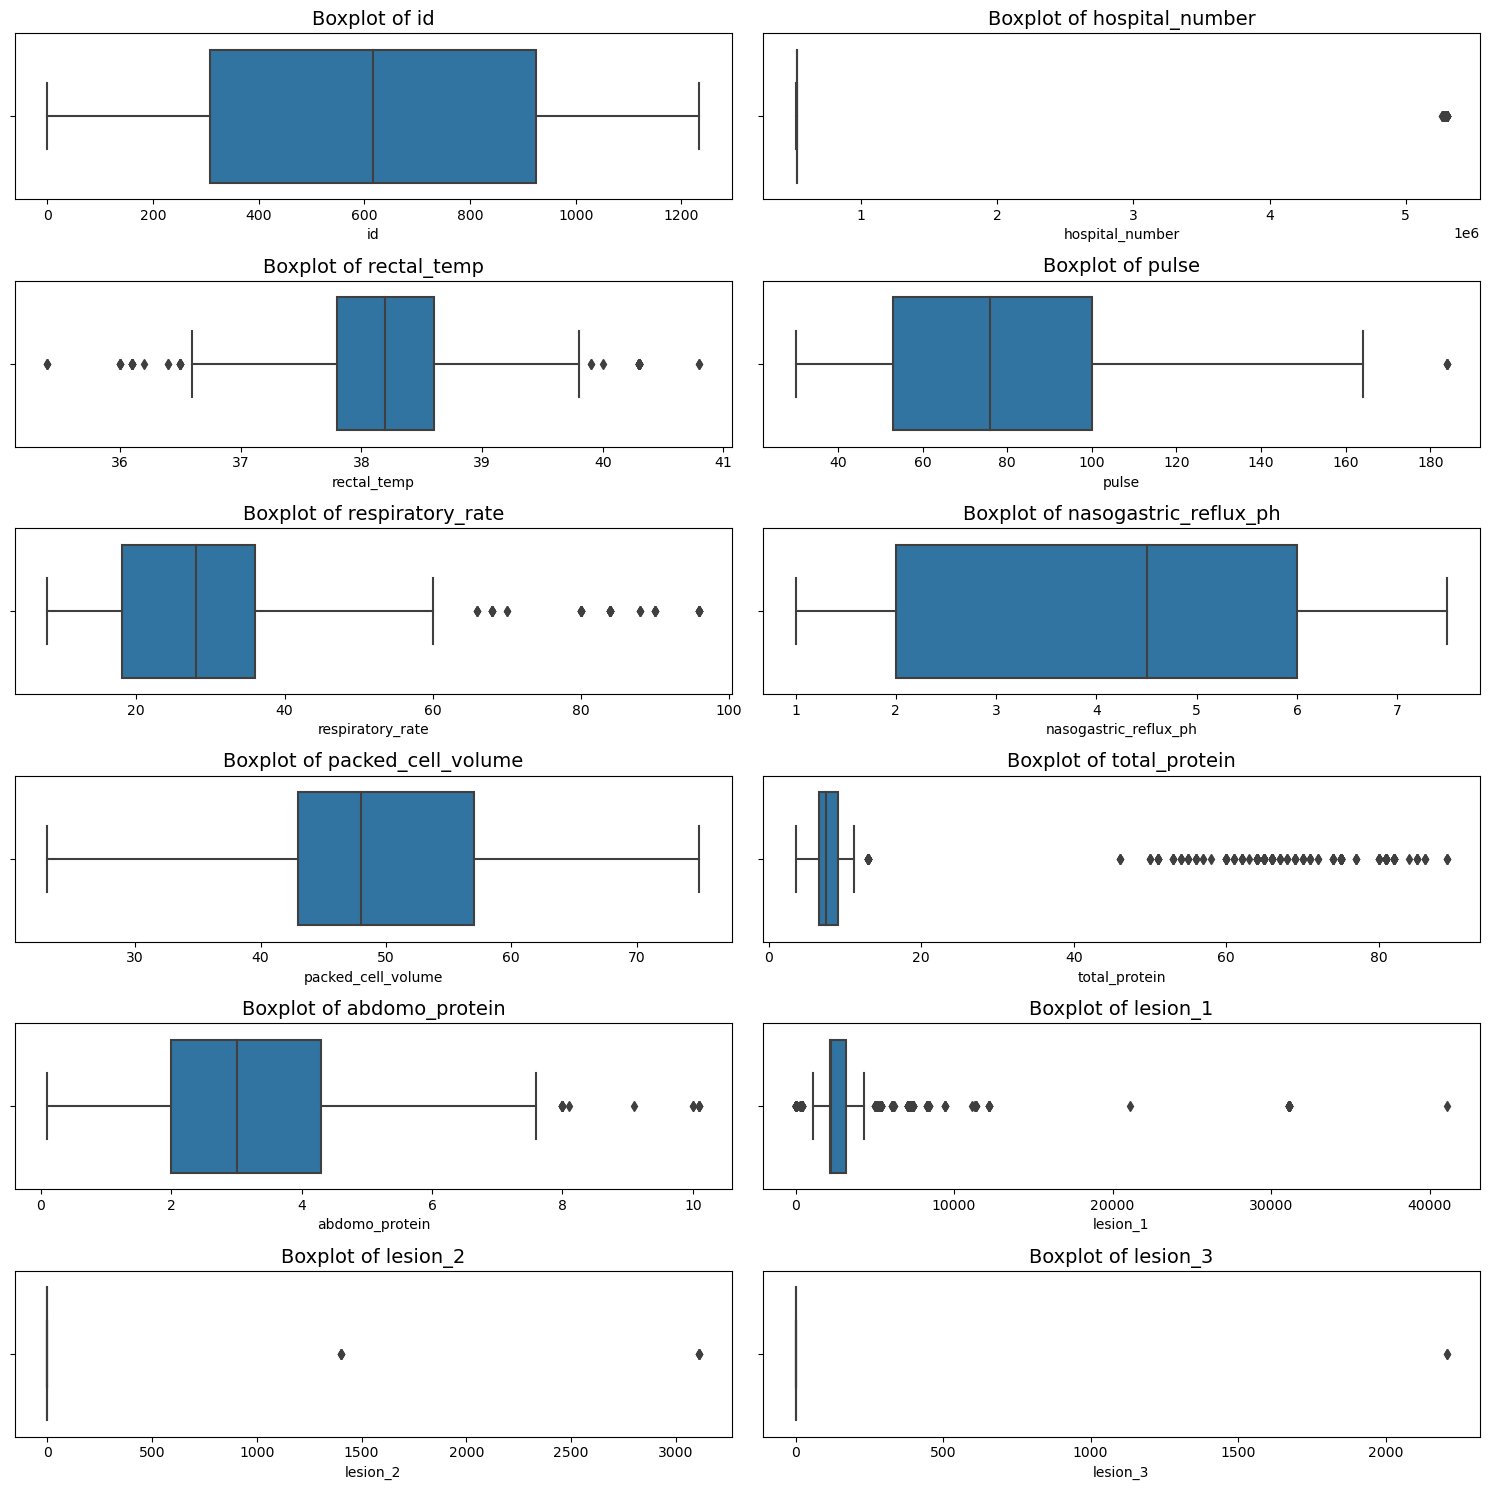

In [8]:
plot_boxplots(df)

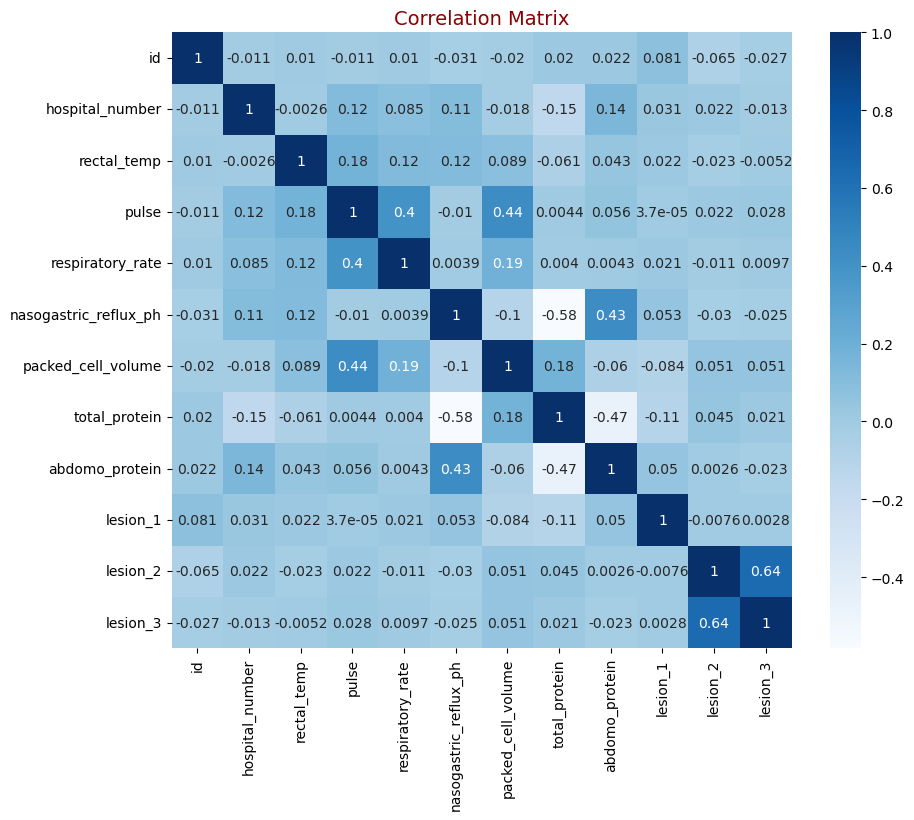

In [9]:
mat = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(data=mat,annot=True , cmap='Blues')
plt.title("Correlation Matrix",c='darkred',fontsize=14)
plt.show()

In [10]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler ,LabelEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split ,RandomizedSearchCV

In [11]:
le = LabelEncoder()
rs = RobustScaler()
mms = MinMaxScaler()

In [20]:
def preprocessing(x):
    if('outcome' in x.columns):
        x=x.drop(columns='outcome',axis =1)
    x=x.drop(columns='id',axis = 1)
    num = x.select_dtypes(exclude = 'object').columns
    cat = x.select_dtypes(include = 'object').columns
   # x[num] = rs.fit_transform(x[num])
    x[num] = mms.fit_transform(x[num])
    for col in cat:
        x[col].fillna(x[col].mode()[0],inplace = True)
        x[col] = le.fit_transform(x[col])
    return x

In [13]:
df['outcome'].unique()

array(['died', 'euthanized', 'lived'], dtype=object)

In [14]:
X=preprocessing(df)
y = df['outcome'].map({'died':0 , 'euthanized':1 , 'lived':2 })

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [115]:
rfc = RandomForestClassifier(random_state=42)

In [116]:
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [117]:
train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)

In [118]:
print(" F1 score TRAIN :: ",f1_score(y_train,train_pred,average='micro'))
print(" F1 score TEST :: ",f1_score(y_test,test_pred,average='micro'))

 F1 score TRAIN ::  1.0
 F1 score TEST ::  0.7004048582995951


In [80]:
from sklearn.model_selection import cross_val_score

In [81]:
cv_score= cross_val_score(estimator=rfc ,X=X,y=y, cv=5)

In [82]:
cv_score.mean()

0.7004048582995952

In [83]:
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [3, 5, 10, 20],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  ,               # Method of selecting samples for training each tree
    'random_state':[42]
}

In [84]:
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)


In [85]:
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 5, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100],
                                        'random_state': [42]},
                   random_state=42)

In [86]:
random_search.best_params_

{'random_state': 42,
 'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 20,
 'bootstrap': False}

In [87]:
rfc = random_search.best_estimator_

In [88]:
train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)

In [89]:
print(" F1 score TRAIN :: ",f1_score(y_train,train_pred,average='micro'))
print(" F1 score TEST :: ",f1_score(y_test,test_pred,average='micro'))

 F1 score TRAIN ::  0.9625151148730351
 F1 score TEST ::  0.6887254901960784


In [90]:
xgb = XGBClassifier()

In [91]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [92]:
train_pred = xgb.predict(X_train)
test_pred = xgb.predict(X_test)

In [93]:
print(" F1 score TRAIN :: ",f1_score(y_train,train_pred,average='micro'))
print(" F1 score TEST :: ",f1_score(y_test,test_pred,average='micro'))

 F1 score TRAIN ::  1.0
 F1 score TEST ::  0.7058823529411765


In [94]:
from sklearn.neighbors import KNeighborsClassifier

In [95]:
knn = KNeighborsClassifier()

In [96]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [97]:
train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

In [98]:
print(" F1 score TRAIN :: ",f1_score(y_train,train_pred,average='micro'))
print(" F1 score TEST :: ",f1_score(y_test,test_pred,average='micro'))

 F1 score TRAIN ::  0.7037484885126964
 F1 score TEST ::  0.5661764705882353


In [99]:
param_grid = {
    'n_neighbors': range(1, 21),          # Number of neighbors to use
    'weights': ['uniform', 'distance'],   # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'leaf_size': [10, 20, 30, 40, 50],    # Leaf size passed to BallTree or KDTree
    'p': [1, 2]                           # Power parameter for the Minkowski metric
}

In [100]:
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)


In [101]:
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=100,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'n_neighbors': range(1, 21),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [102]:
knn = random_search.best_estimator_

In [103]:
from sklearn.linear_model import LogisticRegression

In [104]:
lr = LogisticRegression()

In [105]:
lr.fit(X_train,y_train)

C:\Users\sudhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [106]:
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

In [107]:
print(" F1 score TRAIN :: ",f1_score(y_train,train_pred,average='micro'))
print(" F1 score TEST :: ",f1_score(y_test,test_pred,average='micro'))

 F1 score TRAIN ::  0.660217654171705
 F1 score TEST ::  0.6617647058823529


In [108]:
from sklearn.ensemble import VotingClassifier

In [161]:
vc = VotingClassifier(estimators=[
    ('RanfomForest',rfc),
    ('XGB',xgb),
    ('KNN',knn),
    ('LogisticRegression',lr)
    #('ANN',clf)
])

In [162]:
vc.fit(X_train,y_train)

C:\Users\sudhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('RanfomForest',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5,
                                                     n_estimators=50,
                                                     random_state=42)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_ca...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('KNN',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   leaf_size=40, n_neighbors=16,
                                                   p=1, weights='distance')),
                             ('LogisticRegression', LogisticRegression())])

In [163]:
test_clean = preprocessing(test)

In [164]:
test_clean.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,0,0,0.002645,0.541667,0.027027,0.126437,2,2,3,1,...,1,0.365385,0.042303,0,0.22,0,0.000000,0.0,0.0,0
1,1,0,0.001478,0.458333,0.513514,0.448276,1,3,0,2,...,1,0.403846,0.024677,2,0.25,0,0.070974,0.0,0.0,1
2,1,0,0.001417,0.354167,0.202703,0.034483,1,2,1,1,...,1,0.163462,0.024677,1,0.15,1,0.070878,0.0,0.0,1
3,0,0,0.002798,0.229167,0.351351,0.126437,1,3,4,1,...,0,1.000000,0.905993,2,0.09,1,0.045002,0.0,0.0,0
4,1,0,0.001765,0.479167,0.094595,0.034483,1,2,0,1,...,1,0.269231,0.034078,1,0.25,1,0.070974,0.0,0.0,1


In [165]:
pred = vc.predict(test_clean)

In [55]:
sub = pd.DataFrame({
    'id':test.id,
    'target':pred
})

In [56]:
sub['outcome'] = sub['target'].map({0:'died',1:'euthanized',2:'lived'})

In [190]:
sub.drop(columns='target',axis=1,inplace =True)

In [191]:
sub.to_csv('submission.csv',index=False)

In [15]:
from tensorflow import keras
from tensorflow.keras import layers ,Sequential
from tensorflow.keras.layers import Dropout , Dense
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
X1=df.drop(columns=['id','outcome'])
y1=df['outcome'].map({'died':0 , 'euthanized':1 , 'lived':2 })

In [19]:
X1.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes


In [18]:
X1 = p


ValueError: could not convert string to float: 'yes'

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [151]:
clf = Sequential()

In [152]:
clf.add(Dense(units = 27 ,activation ='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(units = 27 , activation='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(1,activation ='softmax'))

In [153]:
clf.compile(optimizer='adam',
              loss='categorical_crossentropy')

In [154]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

In [ ]:
clf.fit(x=X_train,
        y=y_train,
        epochs=100,
        validation_data=(X_test,y_test),verbose=1,
        callbacks=[early_stop]
       )

In [129]:
losses = pd.DataFrame(clf.history.history)

<Axes: >

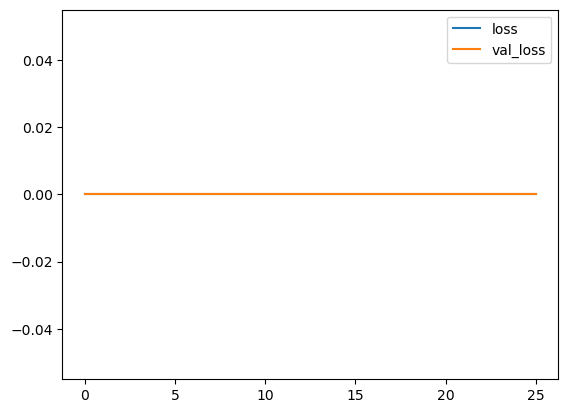

In [130]:
losses.plot()

In [132]:
test_preds=clf.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\sudhi\anaconda3\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\sudhi\anaconda3\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [365]:
preds=pd.DataFrame(clf.predict(test_clean))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


In [366]:
predicted_classes = np.argmax(preds, axis=1)

In [367]:
predicted_classes=pd.DataFrame(predicted_classes)

In [368]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [369]:
train_pred=pd.DataFrame(np.argmax(pd.DataFrame(train_pred),axis=1))
test_pred=pd.DataFrame(np.argmax(pd.DataFrame(test_pred),axis=1))

In [370]:
print("F1 train :: ",f1_score(y_train,train_pred,average='micro'))
print("F1 test :: ",f1_score(y_test,test_pred,average='micro'))

F1 train ::  0.8548972188633615
F1 test ::  0.5955882352941176


In [371]:
train_pred.value_counts()

2    336
0    317
1    174
Name: count, dtype: int64